<a href="https://colab.research.google.com/github/gaurovgiri/poem-firecat/blob/master/Assignment_cWGAN_GP_in_Fashion_MNIST_dataset(PyTorch)_Student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional Wasserstein Generative Adversarial Network-Gradient Penalty (CWGAN-GP) in Fashion-MNIST dataset

---

<b><div style="text-align: right">[Total Points: 15]</div></b>

In this assignment, you will implement cWGAN-GP in Fashion MNIST dataset using PyTorch. Note that you will need to comment the training portion during submission, as well as submit the training generated files 'gen_score.txt' and 'crit_score.txt'.


Up till now, in this unit, you have learned various types of GANS. Below are a list of them with their short summary:

1. **Vanilla GAN** uses ANN for generator and discriminator networks, but suffers from mode collaspe.
2. **Wasserstein GAN(WGAN)** modifies loss function and discriminator of GAN by introduction of wasserstein loss and critic, respectively that prevents mode collaspe and training instability.
3. **Deep Convolutional GAN(DCGAN)** resort to CNNs instead of ANNs for generator and discriminator with spatial upsampling(```Conv2D```) and downsampling(```Conv2DTranspose```) layer for image generation, respectively.
4. Finally, **Conditional GAN(CGAN)** that uses adversally learned inference(ALI) to have control over the generated outputs.

Now, in this assignment, you will be extending your knowledge on GAN by implementing an improvement upon WGAN, known as WGAN-Gradient Penalty(GP)(Gulrajani, et al., 2017). WGAN-GP allows improved(faster and better convergence) training than WGAN(that uses weight clipping). In addition, you must apply ALI(CGAN) to be able to generate desired output on the fly.

## Learning objectives

By the end of this assignment, student should be able to:

1. Load Fashion-MNIST dataset and format the data such that it is ready for training the GAN.

2. Explain limitations of WGAN and why WGAN-GP is better.

3. Construct elements of CWGAN-GP and training function, which are:
  1. Networks - Generator and Critic

  2. Training functions(According to WGAN-GP algorithm)

4. Train the CWAN-GP model on Fashion-MNIST dataset and generate fake images.


## Imports and configs


In [1]:
# Importing required libraries
from os import mkdir, path
import pickle
import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torchvision

from IPython import display

In [2]:
RANDOM_SEED = 0 # For reproducibility

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

## Dataset Description [Requires changes]


### Fashion MNIST Dataset

*Source* : https://github.com/zalandoresearch/fashion-mnist/blob/master/LICENSE<br>
*Author* : Zalando SE<br>
*License* : Copyright © 2017 Zalando SE, https://tech.zalando.com<br>

This dataset consists of 60000 28x28 grayscale images of 10 categories of fashion clothings. The categories are 'T-Shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag' and 'Ankle Boot'. Likewise, there are 10000 test images.

Dataset   $\hspace{20mm}$   No of images<br>
Train Set$\hspace{25mm}$ 60000<br>
Test Set  $\hspace{25mm}$ 20000<br>


## Load the dataset


### Exercise 1: Implement function to normalize the images

<b><div style="text-align: right">[POINTS: UNGRADED]</div></b>

Before feeding the labelled images to GANs, we require normalize the pixel values.

- __Tasks__

 1. Create `torchvision.transforms.Normalize` Transform object with `mean=0.5` and `std=0.5`. The torchvision image have value range `[0, 1]`. This transform will convert them to range `[-1, 1]`.


In [3]:
### Ex-1-Task-1
norm_transform = None
### BEGIN SOLUTION
# your code here
norm_transform = torchvision.transforms.Normalize((0.5,), (0.5,))
### END SOLUTION

### Dataset preparation steps

1. Load the Fashion MNIST dataset from ```torchvision.datasets.FashionMNIST``` in variables ```train_dataset``` and ``test_dataset``` for images, labels of training and test set, respectively. Apply transformation defined above.

2. Combine the training and test set into a single set for training the generator model.

3. Keep image shape for future reference.


In [4]:
# Load the dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    norm_transform,
])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Combine the train and test data for training
all_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

# Get image shape
IMAGE_SHAPE = all_dataset[0][0].size()

# Shape of the training dataset
print(f'The len of all data: {len(all_dataset)}, Image Shape: {IMAGE_SHAPE}')

100%|██████████| 26421880/26421880 [00:01<00:00, 14891029.86it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 271404.42it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4947760.50it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23444383.27it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

The len of all data: 70000, Image Shape: torch.Size([1, 28, 28])


### Exercise 2: Create an input pipeline used training the GAN

<b><div style="text-align: right">[POINTS: 1]</div></b>

Now you must generate the input pipeline using ```torch.utils.data.Dataloader``` stored in variable ```train_dataloader``` that will be used for training GAN model.

- __Tasks__

 1. Create dataloader object with batch size defined below, `shuffle=True` using concatenated dataset we created above,

 Note: Below are few constants that will be used for generating the data pipeline. Store the dataset in ```train_dataset```.


In [5]:
BATCH_SIZE = 64 # Batch size

In [6]:
### Ex-2-Task-1
# Create dataloader
train_dataloader = None
### BEGIN SOLUTION
# your code here
train_dataloader = torch.utils.data.DataLoader(all_dataset, batch_size=BATCH_SIZE, shuffle=True)
### END SOLUTION
len(train_dataloader)

1094

In [7]:
# INTENTIONALLY LEFT BLANK

### Utility functions to calculate output shape from `Conv2d` and `ConvTranspose2d` layer.


In [8]:
def int_to_tuple(variable):
    if isinstance(variable, (int, str)):
        variable = (variable, variable)
    elif len(variable) == 1:
        variable = (variable[0], variable[0])
    return variable

def conv2d_output_shape(input_shape, kernel_size, stride=1, padding=0, dilation=1):
    input_shape = int_to_tuple(input_shape)
    kernel_size = int_to_tuple(kernel_size)
    stride = int_to_tuple(stride)
    padding = int_to_tuple(padding)
    dilation = int_to_tuple(dilation)

    if padding[0] == 'same':
        return input_shape
    elif padding[0] == 'valid':
        padding = (0, 0)

    return tuple((input_shape[i] + 2*padding[i] - dilation[i]*(kernel_size[i] - 1) - 1) // stride[i] + 1 for i in range(2))

def convtranspose2d_output_shape(input_shape, kernel_size, stride=1, padding=0, dilation=1):
    input_shape = int_to_tuple(input_shape)
    kernel_size = int_to_tuple(kernel_size)
    stride = int_to_tuple(stride)
    padding = int_to_tuple(padding)
    dilation = int_to_tuple(dilation)

    return tuple((input_shape[i] - 1)*stride[i] - 2*padding[i] + dilation[i]*(kernel_size[i] - 1) + 1 for i in range(2))

## CWGAN-GP Model Implementation


### Limitation of WGAN

WGAN aims for stable training of GANs, but it can generate poor samples or fail to converge. These problems are primarily from the use of weight clipping in WGAN. Recalling, weight clipping were to enforce a 1-Lipschitz constraint on the critic model, but results in:

1. __Capacity underuse__:
   Implementing Lipshitz constraint by the use of weight clipping results in the critic(discriminator) to learn simple approximation functions.
   
   
2. __Exploding and vanishing gradients__:
    WGAN optimization has unstable training because of the mismatch of weight clipping(constraint) and cost function, resulting in problem of exploding and vanishing gradient.


__WGAN-GP__ provides an alternative training method to weight clipping. In short, WGAN-GP penalizes the norm of the gradient of the critic with respect to the inputs(Gulrajani et al., 2017). WGAN-GP performs better than WGAN, and most importantly provides faster and stable training.

Your first major task of this assignment is the __implementation the WGAN-GP's Generator and Critic model__.


The CWGAN-GP's Generator and Critic architecture is closely related to CDCGAN, with some differences in the output activation functions and normalization layers, which will be discussed within their respective sections.

Additionally note, since we are using ALI(condition) for generation of desired image given the label, **you are required to concat some representation of labels with the input images**.


### Exercise 3: Implement Generator of CWGAN-GP.

<b><div style="text-align: right">[POINTS: 3]</div></b>

The architecture of Generator($G(z \vert y; \theta_g)$, where $\theta_g, z, y$ are the parameters of generator, noise sample and target label, respectively) that you are implementing in this assignment is shown in the figure below.

<center>
<figure>


<p>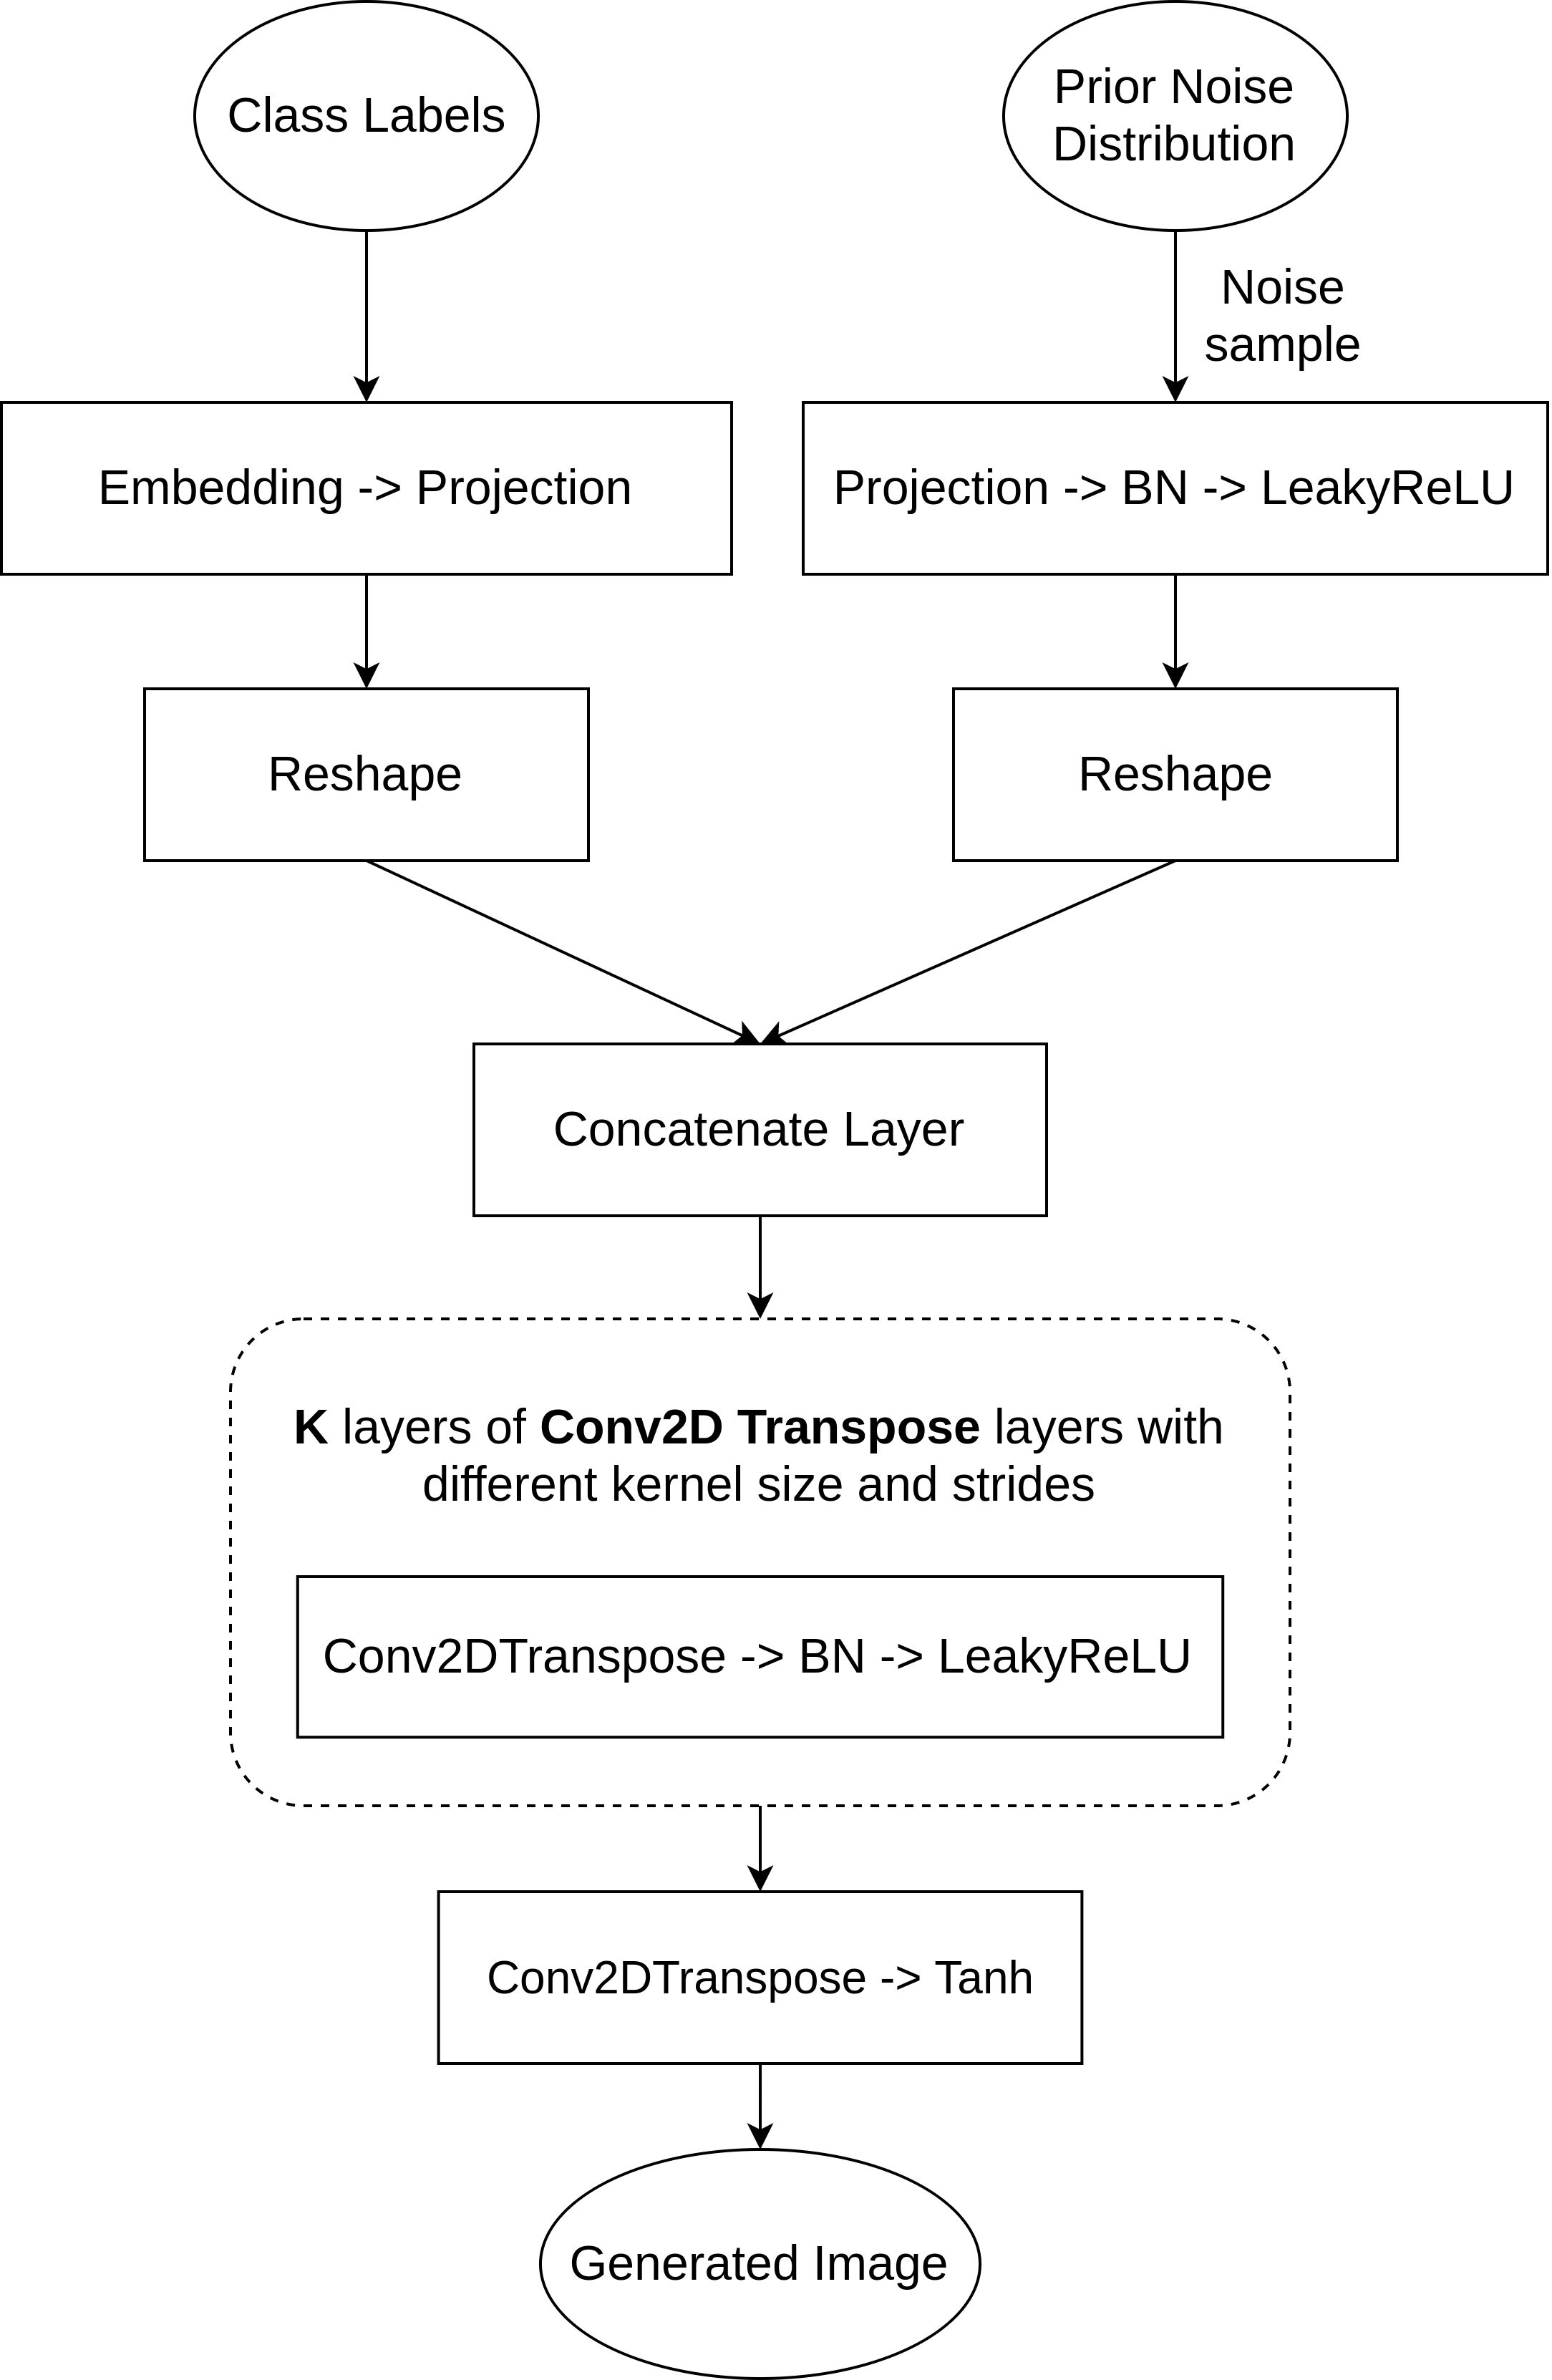</p>
<figcaption align="center">Figure 1: Generator of CWGAN-GP</figcaption>
</figure>
</center>

- __Tasks__

    1. Use `nn.Module` subclassing approach and create a Generator model.
      - Use ```__init__``` method to generate the layers of Generator with given attributes.
      - Use ```forward``` method develop forward pass for the given input data.

    Note: The skeletal of the class ```Generator``` is given in below section. Use the parameters as stated in the docstring for generation of model.


- __Key notes regarding the model__

  - Choose "K"(Number of ```ConvTranspose2d -> BN -> LeakyReLU``` layers) in above figure as your liking. However, the sequence of layers in Generator must be as shown in the figure above.

  - Remember the input of generator will be list, ```(noise_sample, train_label)``` with ```noise_sample``` of shape ```(BATCH_SIZE x NOISE_DIM)``` and ```train_label``` of shape ```(BATCH_SIZE,)```.

  - The output shape of the generator must be equal to the shape of batch of Fashion MNIST images of dimension ```(BATCH_SIZE x 1 x 28 x 28)```.

  


The number of classes, dimension of latent space/noise sample, embedding dimension and alpha for LeakyReLU  for this assignment is given below.


In [9]:
N_CLASSES = len(train_dataset.classes) # Number of classes
NOISE_DIM = 100 # Dimension of latent space
EMBEDDING_DIM = 50 # Embedding dimension
LEAKY_ALPHA = 0.2 # Alpha value for leaky ReLU

In [10]:
class Reshape(nn.Module):
    """
    Reshape the input tensor to target shape, ignores the batching dim=0
    """
    def __init__(self, target_shape):
        super(Reshape, self).__init__()
        self.target_shape = target_shape

    def forward(self, inputs):
        assert np.prod(self.target_shape) == np.prod(inputs.size()[1:]), f"Cannot reshape input {inputs.size()[1:]} to {self.target_shape}"
        return inputs.view((-1, *self.target_shape))

class Concatenate(nn.Module):
    def __init__(self, dim=-1):
        super(Concatenate, self).__init__()
        self.dim = dim

    def forward(self, inputs):
        return torch.concat(inputs, dim=self.dim)

### Solution Code Snippet

<details>
    <summary> Click here and copy the code to the cell below </summary>
    
         self.label_network = nn.Sequential(
            
             # label embedding layer
             None,
             # label projection layer
             None,
             

             # label reshape
             Reshape((1, *conv_start_shape[1:])),
        )

        # Define noise projection layer(Linear) and Batch Norm1d and LeakyReLU layers in noise network;
        # The noise network should output tensor of shape (batch_size, conv_start_channels, conv_start_height, conv_start_width)

        self.noise_network = nn.Sequential(
            
            # noise projection layer
            None,
            None,
            None,
            

            # noise reshape
            Reshape(conv_start_shape),
        )

        # concatenation along channel dimension
        self.concat = Concatenate(dim=1)

        # From list of params for ConvTranspose2d layers, last one will be used as output layer and
        # Remaining will be used to form stack of ConvTranspose2d -> Batch Norm2d -> LeakyReLU
        self.deconv_stack = nn.Sequential()
        for layer_idx, (in_channels, out_channels, kernel_size, stride, padding) in enumerate(zip(
                 (conv_start_shape[0] + 1, *conv_filters[:-2]), # in_channels for first ConvTranspose Layers is conv_start_channels + 1(after concatenating label projection)
                 conv_filters[:-1], conv_kernels[:-1],
                 conv_strides[:-1], conv_paddings[:-1],
             )):
            

            # Instantiate ConvTranspose2d, BatchNorm2d, LeakyRelu
            
            deconv_layer = None
            batch_norm = None
            leaky_relu = None
            

            # Add to deconv stack
            self.deconv_stack.add_module(f'deconv{layer_idx}', deconv_layer)
            self.deconv_stack.add_module(f'batch_norm{layer_idx}', batch_norm)
            self.deconv_stack.add_module(f'leaky_relu{layer_idx}', leaky_relu)
        
        # Add output conv layer
        self.deconv_stack.add_module(f'deconv_output', nn.ConvTranspose2d(
            conv_filters[-2], conv_filters[-1], conv_kernels[-1],
            conv_strides[-1], conv_paddings[-1]
        ))
        
    def forward(self, noise, label):
        '''
        Performs forward pass for the generator network. Specify the computation
        done by each layer here.

        Parameters
        ----------
        noise: Tensor
            noise sample of shape (batch_size, NOISE_DIM)
        
        label: Tensor
            labels of shape (batch_size,) to condition the generator

        Returns
        -------
        output: tensorflow.Tensor
            Shape: (BATCH_SIZE, 1, image_height, image_width)
            generated fake image
        '''
        # Forward pass noise through noise projection network
        noise_processed = None
        

        # Forward pass label through label embedding and projection network
        label_processed = None
        

        # concat label and noise
        conv_inputs = self.concat([noise_processed, label_processed])

        # Forward pass conv_inputs through deconv_stack to get output
        output=None
        
    
</details>


In [11]:
### Ex-3-Task-1

class Generator(nn.Module):
    '''
    Generator of CWGAN-GP model.

    Attributes
    ----------
    noise_dim: int
        The dimension of latent vector used as noise input in generator
    number_of_classes: int
        The number of unique labels of a classification dataset
    embedding_dim: int
        Output dimension of the embedding layer.
    conv_start_shape: tuple of int
        Shape of first `convTranspose2d` layer. Example: (256,7,7),
        where 1st element is height, 2nd is width and 3rd is the depth
        Hint: Use the elements of this tuple to set dimensions of Reshape and
        projection layers.
    conv_filters: list of int
        List of number of filters to use in each `Conv2DTranspose` layers.
        The length of the list is equal to the number of `Conv2DTranspose`
        layers. `i`th element of the list is the parameter for `i`th
        `Conv2DTranpose` layer.
        Example: For three layers with number of filters 128, 64, 32, the
        list would be [128,64,32]
    conv_kernels: list of int
        List of kernel size to use in each `corresponding` `Conv2DTranspose` layers.
        `i`th element of the list is the parameters for `i`th `Conv2DTranpose` layer.
    conv_strides: list of int
        List of strides to use in each `corresponding` `Conv2DTranspose` layers.
        `i`th element of the list is the parameters for `i`th `Conv2DTranpose` layer.
    conv_paddings: list of int
        List fo padding to use in each `corresponding` `ConvTranspose2d` layers.
        `i`th element of the list is the parameters for `i`th `Conv2DTranpose` layer.
    leaky_relu_alpha: float
        Alpha value for leakyReLU activation

    Methods
    -------
    call(inputs):
        Performs forward pass for the generator network
    '''
    def __init__(self, noise_dim,
                 number_of_classes, embedding_dim,
                 conv_start_shape, conv_filters,
                 conv_kernels, conv_strides, conv_paddings,
                 leaky_relu_alpha, **kwargs):

        '''
        Constructs all the layers of the generator network with the provided attributes

        '''
        super(Generator, self).__init__(**kwargs)

        # Add Embedding Layer and Linear Layer for label mapping in label_network Sequential Module
        # Label Network should output tensor of shape (batch size, 1, conv_start_shape_height, conv_start_shape_width)

        ### BEGIN SOLUTION
        # your code here
        self.label_network = nn.Sequential(
            nn.Embedding(number_of_classes, embedding_dim),
            nn.Linear(embedding_dim, np.prod(conv_start_shape)),
            Reshape((1, *conv_start_shape[1:]))
        )

        self.noise_network = nn.Sequential(
            nn.Linear(noise_dim, np.prod(conv_start_shape)),
            nn.BatchNorm1d(np.prod(conv_start_shape)),
            nn.LeakyReLU(leaky_relu_alpha),
            Reshape(conv_start_shape)
        )

        self.concat = Concatenate(dim=1)

        self.deconv_stack = nn.Sequential()
        for layer_idx, (in_channels, out_channels, kernel_size, stride,padding) in enumerate(zip((conv_start_shape[0] + 1, *conv_filters[:-2]), conv_filters[:-1], conv_kernels[:-1], conv_strides[:-1], conv_paddings[:-1],)):
            deconv_layer = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
            batch_norm = nn.BatchNorm2d(out_channels)
            leaky_relu = nn.LeakyReLU(leaky_relu_alpha)

            self.deconv_stack.add_module(f"deconv_layer_{layer_idx}", deconv_layer)
            self.deconv_stack.add_module(f"batch_norm_{layer_idx}", batch_norm)
            self.deconv_stack.add_module(f"leaky_relu_{layer_idx}", leaky_relu)

        self.deconv_stack.add_module(f'deconv_output', nn.ConvTranspose2d(conv_filters[-2], conv_filters[-1], conv_kernels[-1], conv_strides[-1], conv_paddings[-1]))

    def forward(self, noise, label):
        '''
        Performs forward pass for the generator network. Specify the computation
        done by each layer here.

        Parameters
        ----------
        noise: Tensor
            noise sample of shape (batch_size, NOISE_DIM)

        label: Tensor
            labels of shape (batch_size,) to condition the generator

        Returns
        -------
        output: tensorflow.Tensor
            Shape: (BATCH_SIZE, 1, image_height, image_width)
            generated fake image
        '''
        # Forward pass noise through noise projection network
        noise_processed = self.noise_network(noise)


        # Forward pass label through label embedding and projection network
        label_processed = self.label_network(label)


        # concat label and noise
        conv_inputs = self.concat([noise_processed, label_processed])

        # Forward pass conv_inputs through deconv_stack to get output
        output = self.deconv_stack(conv_inputs)


        ### END SOLUTION

        return output

In [12]:
assert callable(Generator), 'Run the Generator block of code'


### Exercise 4: Implement Critic(Discriminator) of CWGAN-GP.

<b><div style="text-align: right">[POINTS: 3]</div></b>

The architecture of Critic($D(x \vert y; \theta_d)$ where $\theta_g, x, y$ are the parameters of generator, input images, and labels, respectively) that you are implementing in this assignment is shown in the figure below.

<center>
<figure>


<p>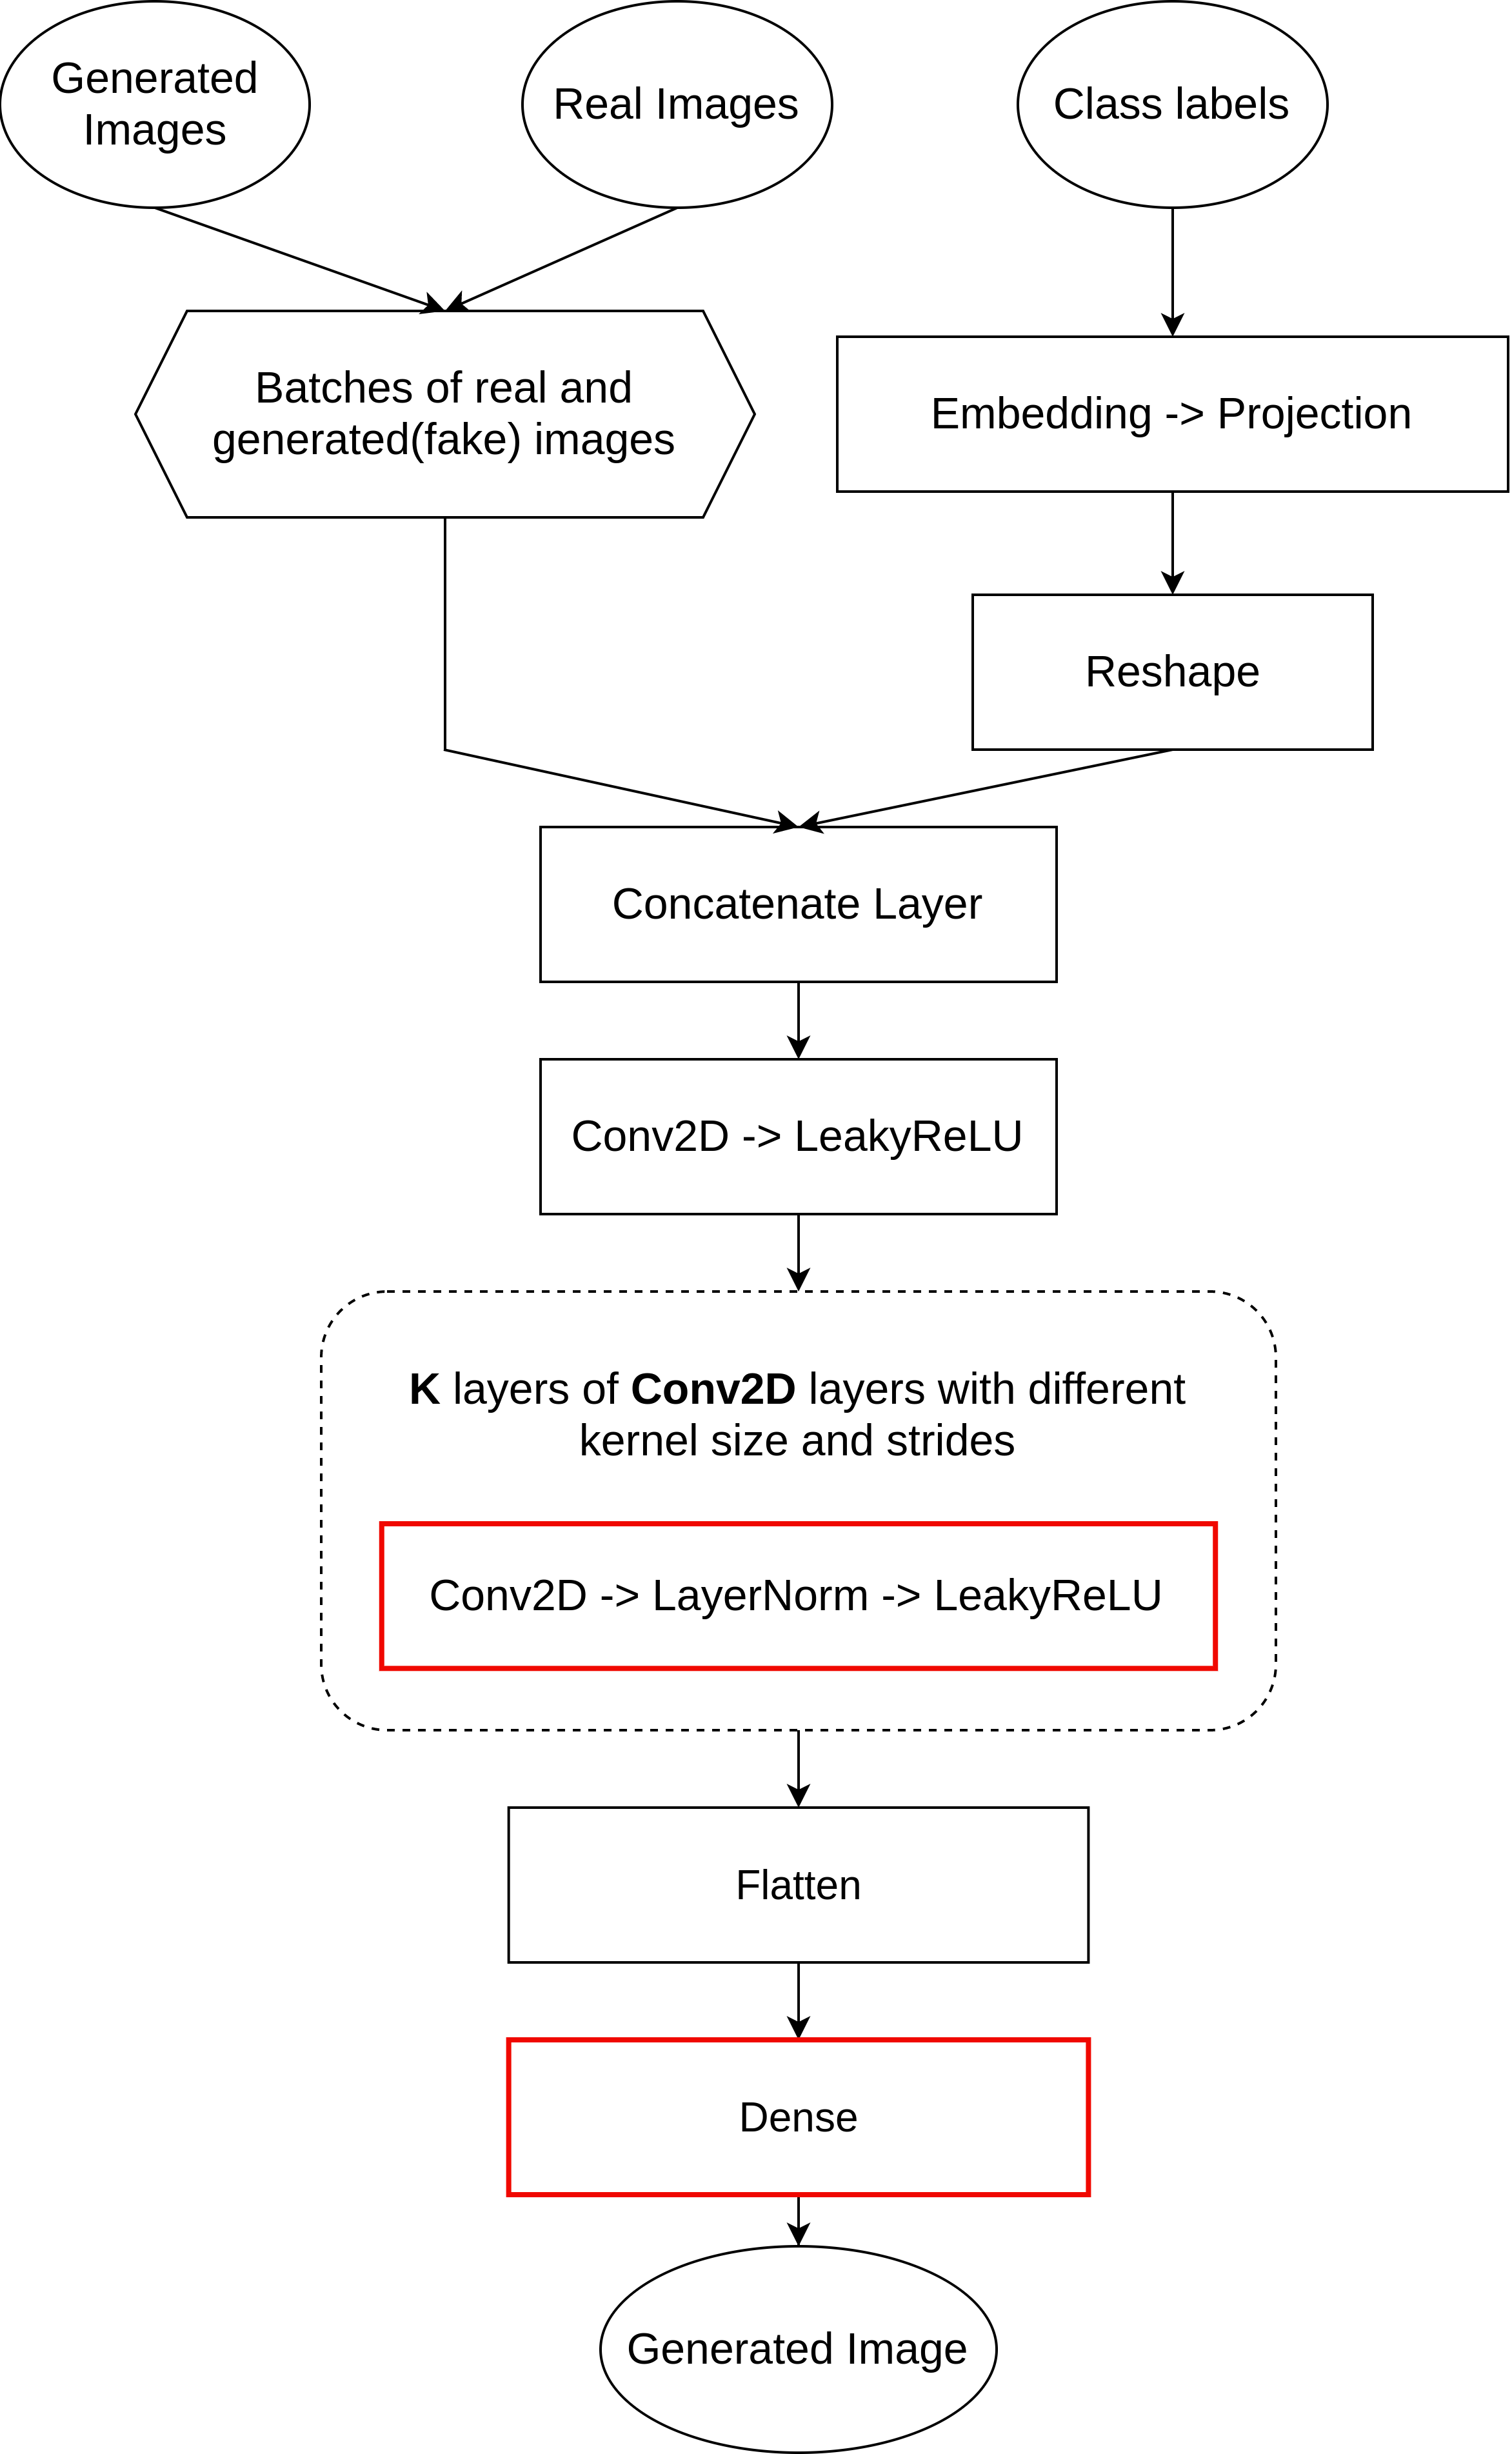</p>
<figcaption align="center">Figure 2: Critic of CWGAN-GP</figcaption>
</figure>
</center>

WGAN-GP has differences in the critic model from the CDCGAN of the reading that are shown in red-blocks in figure above, in short:
1. __No batch normalization in critic__ because WGAN-GP's training objective function (that will you learn in later sub-section) isn't valid in this setting. Mainly, the penalization of norm of critic's gradient is with respect to each input independently, not entire batch(Gulrajani et al., 2017). Instead, you will be using layer normalization (```nn.LayerNorm```) that normalizes the inputs across the features, independent of the mini-batch. The layer norm should be instantiated by passing output shape from conv layer i.e.,`(out_channels, conv_out_height, conv_out_width)`.
    __Apply layernormalization across axis 1,2 and 3__.

2. __No activation function at the output layer__. Recall, Critic is similar to discriminator in GAN, but with no activation at output layer. Critic's value can range from −∞ and  ∞.


- __Tasks__

    - Use model subclassing approach and create a Critic model.
      - Use ```__init__``` method to generate the layers(except label projection and label reshape) of Critic with given attributes.
      - Use ```forward``` method develop forward pass for the given input dataset.

    Note: The skeletal of the class ```Critic``` is given in below section. Use the parameters as stated in the docstring for generation of model.


- __Key notes regarding the model__
    
    You require using the key notes provided in Generator model's section for implementing Critic model. However, the Critic model has a few changes in the input and output, which are:
  
  - Choose "K"(Number of ```ConvTranspose2d -> LN -> LeakyReLU``` layers) in above figure as your liking. However, the sequence of layers in Critic must be as shown in the figure above.
  
  - The input of critic will be tuple of data ```(train_data, train_label)``` with ```train_data``` of shape ```(BATCH_SIZE x 1 x 28 x 28)```, ```train_label``` of shape ```(BATCH_SIZE x 1)```.

  - The output of the critic is a real-value between $-\infty$ to $+\infty$, i.e. the output shape must be equal to ```(BATCH_SIZE x 1)```.




### Solution Code Snippet

<details>
    <summary> Click and copy here to the cell below </summary>

        self.label_network = nn.Sequential(
            # label embedding layer
            nn.Embedding(None, None),

            nn.Linear(None, np.prod(image_shape[1:])),
            
            # reshape back to 4D tensor
            Reshape((1, *image_shape[1:])),
        )

        self.concat = Concatenate(dim=1)

        # From the list of parameters we will create a stack of `Conv2d-> LayerNorm-> LeakyReLU`
        # The output from the stack should be 4D tensor with shape(batch_size, out_channels of last layers, height, width)
        # use normalized shape defined below as an argument for the LayerNorm layer.
        conv_input_image_shape = image_shape[1], image_shape[2]
        self.conv_stack = nn.Sequential()
        for layer_idx, (in_channels, out_channels, kernel_size, stride, padding) in enumerate(zip(
            (image_shape[0] + 1, *conv_filters[:-1]),
            conv_filters, conv_kernels,
            conv_strides, conv_paddings,
        )):
            # Pre-calculate the output shape from the Conv2d layer.
            conv_input_image_shape = conv2d_output_shape(conv_input_image_shape, kernel_size, stride, padding)
            normalized_shape = (out_channels, *conv_input_image_shape)

            # Define Conv2d, LayerNorm, LeakyReLU for the current index in the stack
            conv_layer, layer_norm, leaky_relu = None, None, None
           

            
            # Add to conv_stack
            self.conv_stack.add_module(f"conv{layer_idx}", conv_layer)
            self.conv_stack.add_module(f"layer_norm{layer_idx}", layer_norm)
            self.conv_stack.add_module(f"leaky_relu{layer_idx}", leaky_relu)
        
        # Output layer to calculate critic from the features from Convolution Stack
        self.output_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(np.prod(conv_input_image_shape)*conv_filters[-1], 1)
        )

    def forward(self, image, label):
        '''
        Performs forward pass for the critic network. Specify the computation
        done by each layer here.

        Parameters
        ----------
        inputs: tuple of tensorflow.Tensor or numpy.ndarray
            Input data to the decoder containing elements,(train_data/generated_data,
            train_labels)

        Returns
        -------
        output: tensorflow.Tensor
            Shape: (BATCH_SIZE, 1)
            real value between -infinity to +infinity
        '''
        # 1. Forward pass through label_network
        label_processed = None

        # 2. concat image and processed label from label_network in channel dimension
        inputs = None

        # 3. Forward pass concatenated features through convolution stack
        conv_outputs = None

        # 4. Forward pass features from conv stack through outputlayer to calculate critic score and store in `output` layer.
        output = None
        
</details>


In [13]:
### Ex-4-Task-1
class Critic(nn.Module):
    '''
    Critic of CWGAN-GP model.

    Attributes
    ----------
    image_shape: tuple or Torch.Shape
        The input size of an image with format (channels, height, width)
    number_of_classes: int
        The number of unique labels of a classification dataset
    embedding_dim: int
        Output dimension of the embedding layer.
    conv_filters: list of int
        List of number of filters to use in each `Conv2d` layers.
        The length of the list is equal to the number of `Conv2d`
        layers. `i`th element of the list is the parameter for `i`th
        `Conv2DTranpose` layer.
        Example: For three layers with number of filters 128, 64, 32, the
        list would be [128,64,32]
    conv_kernels: list of int
        List of kernel size to use in each `corresponding` `Conv2d` layers.
        `i`th element of the list is the parameters for `i`th `Conv2d` layer.
    conv_strides: list of int
        List of strides to use in each `corresponding` `Conv2d` layers.
        `i`th element of the list is the parameters for `i`th `Conv2d` layer.
    conv_paddings: list of int
        List of padding to use in each `corresponding` `Conv2d` layers.
        `i`th element of the list is the parameters for `i`th `Conv2d` layer.
    leaky_relu_alpha: float
        Alpha value for leakyReLU activation function

    Methods
    -------
    build(input_shape):
        Used to generate weights of layers. Students must use the shape of
        input images and thus create label projection and reshape layers.
    call(inputs):
        Performs forward pass for the critic network
    '''
    def __init__(self, image_shape, number_of_classes,
                 embedding_dim, conv_filters,
                 conv_kernels, conv_strides,
                 conv_paddings, leaky_relu_alpha, **kwargs):
        '''
        With the provided attributes constructs all the layers of the critic
        network, except projection and reshape layer for labels.
        '''
        super(Critic, self).__init__(**kwargs)

        # Implement label embedding network by adding Embedding layer and Projection(Linear) in the following Sequential Module
        # The output shape from the label_network should be (batch_size, 1, image_height, image_width)
        self.label_network = nn.Sequential(
            ### BEGIN SOLUTION
            # your code here
            # label embedding layer
            nn.Embedding(number_of_classes, embedding_dim),

            nn.Linear(embedding_dim, np.prod(image_shape[1:])),

            # reshape back to 4D tensor
            Reshape((1, *image_shape[1:])),
        )

        self.concat = Concatenate(dim=1)

        # From the list of parameters we will create a stack of `Conv2d-> LayerNorm-> LeakyReLU`
        # The output from the stack should be 4D tensor with shape(batch_size, out_channels of last layers, height, width)
        # use normalized shape defined below as an argument for the LayerNorm layer.
        conv_input_image_shape = image_shape[1], image_shape[2]
        self.conv_stack = nn.Sequential()
        for layer_idx, (in_channels, out_channels, kernel_size, stride, padding) in enumerate(zip(
            (image_shape[0] + 1, *conv_filters[:-1]),
            conv_filters, conv_kernels,
            conv_strides, conv_paddings,
        )):
            # Pre-calculate the output shape from the Conv2d layer.
            conv_input_image_shape = conv2d_output_shape(conv_input_image_shape, kernel_size, stride, padding)
            normalized_shape = (out_channels, *conv_input_image_shape)

            # Define Conv2d, LayerNorm, LeakyReLU for the current index in the stack
            conv_layer, layer_norm, leaky_relu = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding), nn.LayerNorm(normalized_shape), nn.LeakyReLU(leaky_relu_alpha)



            # Add to conv_stack
            self.conv_stack.add_module(f"conv{layer_idx}", conv_layer)
            self.conv_stack.add_module(f"layer_norm{layer_idx}", layer_norm)
            self.conv_stack.add_module(f"leaky_relu{layer_idx}", leaky_relu)

        # Output layer to calculate critic from the features from Convolution Stack
        self.output_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(np.prod(conv_input_image_shape)*conv_filters[-1], 1)
        )

    def forward(self, image, label):
        '''
        Performs forward pass for the critic network. Specify the computation
        done by each layer here.

        Parameters
        ----------
        inputs: tuple of tensorflow.Tensor or numpy.ndarray
            Input data to the decoder containing elements,(train_data/generated_data,
            train_labels)

        Returns
        -------
        output: tensorflow.Tensor
            Shape: (BATCH_SIZE, 1)
            real value between -infinity to +infinity
        '''
        # 1. Forward pass through label_network
        label_processed = self.label_network(label)

        # 2. concat image and processed label from label_network in channel dimension
        inputs = self.concat([image, label_processed])

        # 3. Forward pass concatenated features through convolution stack
        conv_outputs = self.conv_stack(inputs)

        # 4. Forward pass features from conv stack through outputlayer to calculate critic score and store in `output` layer.
        output = self.output_layer(conv_outputs)


            ### END SOLUTION

        return output

###### Test Case


In [14]:
assert callable(Critic), 'Run the Critic block of code'


### Exercise 5: Generate instance of Generator and Critic

<b><div style="text-align: right">[POINTS: 2]</div></b>

- __Tasks__

    1. Generate the instance of ```Generator``` model and store it in ```generator``` variable. __[Points: 1]__
    2. Generate the instance of ```Critic``` model and store it in ```critic``` variable. __[Points: 1]__

Note: You can use arbitary number convolutional(with its following) layers with varying number of filter, kernel shape and strides. However, the final output shape of these model must match the ones specified in their respective key notes.


In [15]:
### Ex-5-Task-1

generator = None # Store generator instance
critic = None # Store critic instance
### BEGIN SOLUTION
# your code here
generator = Generator(
    noise_dim=NOISE_DIM,
    number_of_classes=N_CLASSES,
    embedding_dim=EMBEDDING_DIM,
    conv_start_shape=(1,BATCH_SIZE,NOISE_DIM),
    conv_filters=[128, 64, 1],
    conv_kernels=[5, 5, 5],
    conv_strides=[1, 2, 1],
    conv_paddings=[0, 2, 2],
    leaky_relu_alpha=LEAKY_ALPHA
)

critic = Critic(
    image_shape=IMAGE_SHAPE,
    number_of_classes=N_CLASSES,
    embedding_dim=EMBEDDING_DIM,
    conv_filters=[32, 64, 128],
    conv_kernels=[5, 5, 5],
    conv_strides=[2, 2, 1],
    conv_paddings=[2, 2, 2],
    leaky_relu_alpha=LEAKY_ALPHA
)

### END SOLUTION

In [16]:
assert generator is not None, 'Generator instance not created'


## Define the Hyperparameters, optimizers and Utils

Following code blocks provide the hyperparameter, optimizer(values taken from (Gulrajani et al., 2017)) and utility functions that you will be using during the training of WGAN-GP model.

The constants defined below are:
- Since the Critic is trained more times than the Generator, ```TRAIN_STEP_RATIO``` contains the number of times Critic is trained before training the Generator.
- ```EPOCHS``` represent the number of epochs the WGAN-GP is trained.
- ```GP_LAMBDA``` is the penalty for the objective function of WGAN-GP.(Discussed in later subsection).


In [17]:
# Constants
TRAIN_STEP_RATIO = 5 # Ratio of training critic and generator
EPOCHS = 40 # Training epochs
GP_LAMBDA = 10.0 # Penalty for loss function

Code block below contains the optimizers with their hyperparameters that are to be used for training the WGAN-GP.


In [18]:
# Hyperparameters for adam optimizer
learning_rate = 1e-4
beta_1 = 0
beta_2 = 0.9

# Optimizers
# For generator model
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate,
                                               betas=(beta_1,beta_2))

# For critic model
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=learning_rate,
                                               betas=(beta_1,beta_2))

Finally, the utility function present below are:

1. ```gen_noise``` that generates Gaussian normal noise of given ```shape```.
2. ```generate_and_show_images``` that takes the parameter ```model```, a generator model, and then plots the generated images by that model. Each column represent a specific class of generated image.


In [19]:
# Function to generate noise
gen_noise = lambda shape: torch.randn(shape, device=DEVICE)

In [20]:
def denormalize(inputs):
    return (inputs + 1)/2

def generate_and_show_images(model, num_ex = 6):
    '''
    Plot generated fake images given the model.

    Parameters
    ----------
    model: object
        Generator model that generates fake image given noise sample and target
        label
    '''
    # Noise sample
    noise_input = gen_noise((num_ex*len(train_dataset.classes), NOISE_DIM))

    # Various labels for constant male attribute
    label_input = torch.tensor(range(len(train_dataset.classes)), device=DEVICE).repeat(num_ex)

    model_prev_mode = model.training
    model.eval()
    with torch.no_grad():
        predictions = denormalize(model(noise_input, label_input))
        predictions = predictions.permute(0, 2, 3, 1).squeeze().cpu()

    fig = plt.figure(figsize=(20, 12 * num_ex // len(train_dataset.classes)))

    idx_to_class = {v:k for k, v in train_dataset.class_to_idx.items()}

    for i in range(num_ex*len(train_dataset.classes)):
        plt.subplot(num_ex, len(train_dataset.classes), i+1)
        if i in range(0,len(train_dataset.classes)):
            plt.title(idx_to_class[i], fontsize=12)
        plt.imshow(predictions[i], cmap='gray')
        plt.axis('off')

    plt.subplots_adjust(hspace=0.05, wspace=-0.85)
    plt.show()

Let's generate the images from an untrained generator model.


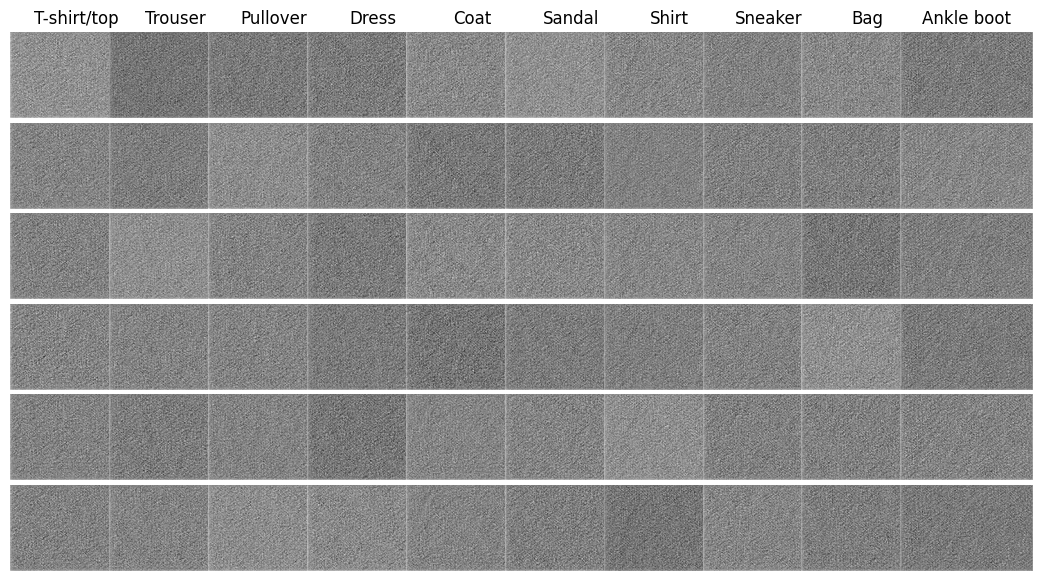

In [21]:
generate_and_show_images(generator)

As you see the generator just spits out random noise images for the given noise sample and labels.


## CWGAN-GP's training function implementation

Now that you have implemented the structure of generator and critic model, the next section of this assignment requires you to:

1. Implement the training function of generator and critic model.
2. Implement the training loop that trains WGAN-GP model.


### Algorithm for training Critic

WGAN-GP uses gradient penalty instead of weight clipping to enforce 1-Lipschitz constraint.  __A differentiable function
is 1-Lipschtiz if and only if it has gradients with norm at most 1 everywhere__(Gulrajani et al., 2017). WGAN-GP works applying soft-constrain on the gradient norm of critic's output with respect to the inputs. The constraint enforced is with a penalty on gradient norm for random sample, $\hat{x} \sim p_\hat{x}$. The new objective for WGAN-GP's critic is given as:

$$V(D) = \underbrace{\mathbb{E}_{\tilde{x} \sim p_g} [D_{\theta_d}(\tilde{x})]-\mathbb{E}_{x\sim p_r} [D_{\theta_d}(x)]}_{\text{Original WGAN critic loss}} + \underbrace{\lambda\mathbb{E}_{\hat{x} \sim p_\hat{x}}[(||\nabla_\hat{x}D_{\theta_d}(\hat{x})||_2-1)^2]}_{\text{Gradient Penalty}}$$

For the conditional version that you are implementing in this assignment, the generated and real images must be conditioned on the target label. So, the objective function is as:
$$V(D) = \mathbb{E}_{\tilde{x} \sim p_g} [D_{\theta_d}(\tilde{x}|y)]-\mathbb{E}_{x\sim p_r} [D_{\theta_d}(x|y)] + \lambda\mathbb{E}_{\hat{x} \sim p_\hat{x}}[(||\nabla_\hat{x}D_{\theta_d}(\hat{x}|y)||_2-1)^2]$$

where,
- $\lambda$ = Penalty coefficient.
- $P_{\hat{x}}$ = Sampling distribution of $\hat{x}$
- $\hat{x}$ = Intermediate sample, sampled uniformly along straight lines between pair of points sampled from data distribution $p_r$ and generator distribution $p_g$.
`
The training of WGAN-GP's critic has additional portion in comparision to WGAN, the computation of gradient penalty. For given the mini-batch({$x_i \sim p_r, y_i$}, $i=1, \cdots, m$) of dataset:

1. Sample noise($z \sim p(z)$) of proper shape using the utility function and constants provided.
2. For update of parameters($\theta_d$), compute the objective function following the steps below:
    1. Generate fake image($\tilde{x} = G_{\theta_g}(z \vert y)$) using the ```generator``` model and store it.(Ensure that ```training=False```, as we don't want to train the generator).
    2. Feed the tuple of generated fake images, target labels and compute and store the output from critic network($D_{\theta_d}(\tilde{x}|y)$).
    3. Feed the tuple of real image, target labels and store the output from critic network ($D_{\theta_d}(x|y)$).
    4. Compute the gradient penalty by:
        1. First, computing the intermediate sample given as:
            $$\hat{x} = \epsilon x + (1-\epsilon)\tilde{x}$$
            where, $\epsilon$ = a random number sampled from Uniform distribution, U[0,1].
        2. Then, feeding the tuple of intermediate samples, target labels and store the output from critic network ($D_{\theta_d}(\hat{x}|y)$).
        3. After that, calculating the norm of gradient ($||\nabla_\hat{x}D_{\theta_d}(\hat{x})||_2 $).
        4. Finally, computing the gradient penalty.
        $$\lambda\mathbb{E}_{\hat{x} \sim p_\hat{x}}[(||\nabla_\hat{x}D_{\theta_d}(\hat{x}|y)||_2-1)^2]$$
    3. Finally, compute the objective(loss) function of critic, given as:
      $$V(D) = \frac{1}{m}\sum_{i=1}^mD(\tilde{x}|y) - \frac{1}{m}\sum_{i=1}^mD(x|y) + \lambda\frac{1}{m}\sum_{i=1}^m(||\nabla_\hat{x}D_{\theta_d}(\hat{x}|y)||_2-1)^2)  $$.
3. Compute the gradient of the objective function($\nabla_\theta(V(D))$).
4. Update the parameters of the generator model using the gradient descent.

$$G_{\theta_d} \leftarrow \nabla_\theta(V(D))$$


### Exercise 6: Training step for Critic

<b><div style="text-align: right">[POINTS: 3]</div></b>

- __Tasks__

    Implement the per mini-batch training function of critic model, ```critic_train_step``` using the following steps.
    1. Generate the noise sample using noise generating function defined above and store it in variable ```noise```. (The noise sample must of shape as mentioned while implementing the generator/critic model, note: __take the batch size from the first axis of ```image```__ as the entire dataset might not be properly divisible by 64).

    2. Compute the fake generated images using noise samples, and labels and store it in ```generated_image```. (Remember to disable gradient and set generator in eval mode``` for this step.)
    3. Compute the scores from critic model for batch of ```image, label``` and ```generated_image, label```. Then, take their means and store them in ```mean_real_pred``` and ```mean_fake_pred```, respectively.
    4. Sample the epsilon value(of shape ```(BATCH_SIZE x 1 x 1 x 1)```) from uniform random distribution, U[0,1] and store in ```epsilon```
    5. Compute the intermediate sample and store in ```inter_sample``` and enable gradient calculation for it.
    6. Forward pass `inter_sample` through critic and get `inter_sample_output`.

    7. For calculating the gradient use `torch.autgrad.grad` function. We'll calculate gradient of `inter_sample_output` wrt `inter_sample`
    8. Calculate the norm of gradient EXCEPT in `Batch Dimension`

    9. Compute the gradient penalty and store in ```gradient_penalty```.
    10. Finally, compute the loss function of the critic model and store in ```loss```.
    11. Do backward pass using loss to calculate gradients and update the model using critic optimizer.


### Solution Code Snippet

<details>
    <summary>Click here and copy the code in the cell below</summary>
    
    # Sample noise of shape (batch_size, NOISE_DIM)
    noise = None
    

    generator_prev_mode, critic_prev_mode = gen.training, crit.training

    gen.eval()
    crit.train()
    with torch.no_grad():
        # Generate fake image
        generated_image = None
        

    critic_optimizer.zero_grad()
    
    # CALULATE MEAN CRITIC SCORE FOR REAL AND GENERATED IMAGE
    mean_real_pred, mean_fake_pred = None, None
    

    # create epsilon tensor of shape (batch_size, 1, 1, 1) from uniform distribution ranging from 0 to 1
    # Create intermidiate sample = image * epsilon + generated_image*(1-epsilon)
    epsilon, inter_sample = None, None
    
    inter_sample.requires_grad = True

    # Forward pass inter_sample
    inter_sample_pred = crit(inter_sample, label)

    # calculate gradient s of inter sample prediction wrt inter_sample
    gradients = torch.autograd.grad(inter_sample_pred, inter_sample,
                                    grad_outputs=torch.ones_like(inter_sample_pred),
                                    retain_graph=True,
                                    create_graph=True)[0]
    gradients = gradients.view(batch_size, -1)
    
    # Calculate gradient penalty, 1st calulate norm of gradient except in batch dim(i.e., dim=-1) and use formula above to calculate gradient penalty
    gradient_penalty = None
</details>


In [22]:
### Ex-6-Task-1
def critic_train_step(gen, crit, image, label):
    '''
    Updates the weights and bias of the critic model given training mini-batch

    parameters
    ----------
    gen: Keras.model
        Generator model of WGAN-GP
    crit: Keras.model
        Critic model of WGAN-GP
    batch: tuple
        mini-batch of the training data (train_data, train_label)

    returns
    -------
    mean_real_pred: float
        Mean of critic's prediction for real set of data
    mean_fake_pred: float
        Mean of critic's prediction for generated set of data
    epsilon: float
        Epsilon value required for generating intermediate sample
    inter_sample: tf.tensor
        Intermediate sample required for gradient penalty
    loss_func: float
        Value of loss/objective function of critic
    '''
    batch_size = image.shape[0]
    # Sample noise of shape (batch_size, NOISE_DIM)

    ### BEGIN SOLUTION
    # your code here
    noise = gen_noise((batch_size, NOISE_DIM))

    generator_prev_mode, critic_prev_mode = gen.training, crit.training
    gen.eval()
    crit.train()

    with torch.no_grad():
        generated_image = gen(noise,label)

    critic_optimizer.zero_grad()

    mean_real_pred, mean_fake_pred = torch.mean(crit(image, label)), torch.mean(crit(generated_image, label))

    epsilon, inter_sample = torch.rand((batch_size, 1, 1, 1), device=DEVICE), image*epsilon + generated_image*(1-epsilon)
    inter_sample.requires_grad = True

    inter_sample_pred = crit(inter_sample, label)

    gradients = torch.autograd.grad(inter_sample_pred, inter_sample,
                                grad_outputs=torch.ones_like(inter_sample_pred),
                                retain_graph=True,
                                create_graph=True)[0]
    gradients = gradients.view(batch_size, -1)
    gradient_penalty = torch.mean((torch.norm(gradients, dim=1) - 1)**2)

    ### END SOLUTION

    # Calculate total loss
    loss = mean_fake_pred - mean_real_pred + GP_LAMBDA * gradient_penalty

    # backward pass and update
    loss.backward()
    critic_optimizer.step()

    if generator_prev_mode:
        gen.train()
    if critic_prev_mode:
        crit.train()

    return loss.item()

###### Test Case


In [23]:
assert callable(critic_train_step), 'Implement train step for critic'



### Algorithm for training Generator
The training of WGAN-GP's Generator is same as that of WGAN, given the mini-batch({$x_i \sim p_r, y_i$}, $i=1, \cdots, m$) of dataset:

1. Sample noise($z \sim p_z$) of proper shape using the utility function and constants provided.
2. For update of parameters($\theta_g$), compute the objective function following the steps below:
    1. Generate fake image($\tilde{x} = G(z \vert y)$) using the ```generator``` model and store it.
    2. Feed the tuple of generated fake images, target labels and compute and store the output from critic network($D(\tilde{x}|y)$).
    3. Finally, compute the objective(loss) function of generator, given as:
      $$V(G) = -\frac{1}{m}\sum_{i=1}^mD(\tilde{x}|y)$$.
3. Compute the gradient of the objective function($\nabla_{\theta_g}(V(G))$).
4. Update the parameters of the generator model using the gradient descent with provided optimizer.

$${\theta_g}_{(\text{new})} \leftarrow \text{Adam}(\nabla_{\theta_g}(V(G)), {\theta_g}_{(\text{old})}, \alpha, \beta_1, \beta_2)$$


### Exercise 7: Training step for Generator

<b><div style="text-align: right">[POINTS: 2]</div></b>

- __Tasks__

    Implement the per mini-batch training function of generator model, ```generator_train_step``` using the following steps:
    1. Store the input images and labels from the ```batch``` on variables ```input, label``` respectively.
    2. Generate the noise sample using noise generating function defined above and store it in variable ```noise```. (Again, use ```image``` to get the batch_size).

    3. Compute the fake generated images using noise samples, and labels and store it in ```generated_image```.
    4. Compute the scores for batch of ```generated_image, labels``` and store it in ```critic_scores```.(Keep the critic gradient calucaltion enabled though we don't update the model).
    5. Finally, compute the loss function of the critic model and store in ```loss```.
    6. Compute the gradients of loss function with respect to the parameters of the generator model..
    7. Ultimately, update the parameters of using ```generator_optimizer```.



### Solution Code Snippet

<details>
    <summary> Click here and copy the code to the cell below</summary>
    
    # Fake generation images using generator by passing noise and label.
    generated_image = None
   

    # while training generator critic we don't disable gradient calulation(doing so breaks the computational graph for backward pass) but weights are not updated.
    # Forward pass fake image and calculate critic_scores
    critic_scores = None
    
</details>


In [24]:
### Ex-7-Task-1
def generator_train_step(gen, crit, image, label):
    '''
    Updates the weights and bias of the generator model given training mini-batch

    parameters
    ----------
    parameters
    ----------
    gen: Keras.model
        Generator model of WGAN-GP
    crit: Keras.model
        Critic model of WGAN-GP
    batch: tuple
        mini-batch of the training data,(train_data, train_label)

    returns
    -------
    mean_critic_scores: float
        Value of objective function of generator
    '''
    # Sampling noise
    batch_size = image.shape[0]
    noise = gen_noise((batch_size, NOISE_DIM))

    generator_prev_mode, critic_prev_mode = gen.training, crit.training

    gen.train()
    crit.eval()

    generator_optimizer.zero_grad()

    # Fake generation images using generator by passing noise and label.
    generated_image = None
    ### BEGIN SOLUTION
    # your code here

    generated_image = gen(noise, label)
    critic_scores = crit(generated_image, label)


    ### END SOLUTION

    # Minimization objective according to step 10 in WGAN training algorithm.
    loss = -torch.mean(critic_scores)

    # Generator weight update
    loss.backward()
    generator_optimizer.step()

    if generator_prev_mode:
        gen.train()
    if critic_prev_mode:
        crit.train()

    return loss.item()

In [25]:
assert callable(generator_train_step), 'Implement train step for Generator'


### Exercise 8: Implement the main training loop

<b><div style="text-align: right">[POINTS: 1]</div></b>

This is the last exercise of this assignment where you have to train the CWGAN-GP model.

- __Tasks__

    Define function ```train_gan```, where required to train the model set number of epochs. Inside the epoch loop perform following steps to pass this exercise:
    1. Enumerate the ```train_dataset```(start the counter from 1).
    2. Train the both critic and generator model in ratio ```TRAIN_STEP_RATIO:1```.
    3. Append the critic(6th return value) and generator loss per iteration to variables ```crit_scores, gen_scores```, respectively.


In [26]:
### Ex-8-Task-1
def train_gan(epochs):
    '''
    Trains both the generator and critic models for the entire training dataset

    Parameters
    ----------
    epochs: int
        Number of epochs to train the CWGAN-GP model

    Returns
    -------
    gen_scores: list of float
        Elements are the generator loss function values per iteration
    crit_scores: list of float
        Elements are the critic loss function values per iteration
    '''

    gen_scores = []
    crit_scores = []

    for epoch in range(epochs):
        epoch_gen_scores = []
        epoch_crit_scores = []
        pbar = tqdm.tqdm(train_dataloader)
        for batch_no, (image, label) in enumerate(pbar, start=1):
            image, label = image.to(DEVICE), label.to(DEVICE)

            crit_loss, gen_loss = None, None
            ### BEGIN SOLUTION
            # your code here
            crit_loss = critic_train_step(generator, critic, image, label)
            gen_loss = generator_train_step(generator, critic, image, label)
            ### END SOLUTION

            epoch_gen_scores.append(gen_loss)
            epoch_crit_scores.append(crit_loss)
            pbar.set_description(f"Epoch: {epoch + 1}/{epochs}; Batch: {batch_no}/{len(train_dataloader)}; Critic Loss: {crit_loss}; Generator Loss: {gen_loss}")

        gen_scores.append(np.mean(epoch_gen_scores))
        crit_scores.append(np.mean(epoch_crit_scores))
        pbar.set_description(f"Epoch: {epoch + 1}/{epochs}; Batch: {batch_no}/{len(train_dataloader)}; Critic Loss: {crit_scores[-1]}; Generator Loss: {gen_scores[-1]}")
        generate_and_show_images(generator, num_ex = 2)

    return gen_scores, crit_scores

### Saving/loading weights of the model

The code blocks present below are for the purpose of training the model and storing the checkpoints.


In [27]:
def load_gan_weights():
    checkpoint = torch.load('./models/checkpoint.pt')
    generator.load_state_dict(checkpoint['generator'])
    critic.load_state_dict(checkpoint['critic'])
    generator_optimizer.load_state_dict(checkpoint['gen_opt'])
    critic_optimizer.load_state_dict(checkpoint['crit_opt'])
    print('GAN weights loading successful')
    return

def save_gan_weights():
    if not path.exists('./models'):
        mkdir('./models')
    torch.save({
        'generator': generator.state_dict(),
        'critic': critic.state_dict(),
        'gen_opt': generator_optimizer.state_dict(),
        'crit_opt': critic_optimizer.state_dict(),
    }, './models/checkpoint.pt')
    print('GAN weights, save successful')
    return

In [28]:
### Model training
### Comment this cell during submission
model_path = './models/checkpoint.pt'

train_models = False
if not path.exists(model_path):
        train_models=True

if train_models:
    generator_score, critic_score = train_gan(EPOCHS)
    with open("gen_score.txt", "wb") as fp:
        pickle.dump(generator_score, fp)
    with open("crit_score.txt", "wb") as fp:
        pickle.dump(critic_score, fp)
    save_gan_weights()
else:
    with open("gen_score.txt", "rb") as fp:
        generator_score = pickle.load(fp)
    with open("crit_score.txt", "rb") as fp:
        critic_score = pickle.load(fp)
    load_gan_weights()

  0%|          | 0/1094 [00:12<?, ?it/s]


RuntimeError: ignored

##### NOTE: Save the previously generated files 'gen_score.txt' and 'crit_score.txt' which you will submit alongside the submission file.


In [ ]:
# INTENTIONALLY LEFT BLANK


The final generated images from CWGAN-GP are as follows.


In [ ]:
generate_and_show_images(generator, num_ex = 6)

While, the loss function of the generator and critic model are as:


In [ ]:
print(f'Final loss of generator: {generator_score[-1]}')
print(f'Final loss of critic: {critic_score[-1]}')

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(generator_score, label='Generator loss')
ax.plot(critic_score, label='Critic loss')
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Loss function value')
ax.set_title('Loss function over number of iterations')
ax.legend()
plt.show()

You have reached the end of this assignment related to implementation and training of CWGAN-GP model. Hopefully you have learned a lot about Generative Adversarial Networks by completing this entire unit.


## References

- Paper
    1. Gulrajani, I., Ahmed, F., Arjovsky, M., Dumoulin, V., & Courville, A. C. (2017). Improved training of wasserstein gans. In Advances in neural information processing systems (pp. 5767-5777).
        - Description on limitations of standard WGAN, how WGAN-GP works and improves over WGAN.
